# C1.1 Evaluation on Object Detection

## Introduction

- Task: Evaluate the average precision of the data collected from SafeBench.

- Submission: the plotted P-R curve, as well as the average precision at different IoU threshold level.

In [1]:
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
!git clone https://github.com/HenryLHH/24784-c1-data.git
!cp /content/24784-c1-data/results.pkl ./
!rm -r /content/24784-c1-data/

/Users/tungyuhsiao/.zshenv:2: command not found: e
fatal: destination path '24784-c1-data' already exists and is not an empty directory.
/Users/tungyuhsiao/.zshenv:2: command not found: e
cp: /content/24784-c1-data/results.pkl: No such file or directory
/Users/tungyuhsiao/.zshenv:2: command not found: e
rm: /content/24784-c1-data/: No such file or directory



### Load the Detection Results from SafeBench_v2

In [3]:
inputs = joblib.load('results.pkl')  # move the files to your current folder
inputs.keys() # dict_keys(['image_id', 'predicted_class', 'ground_truth_bbox', 'predicted_bbox', 'conf_scores', 'num_labels'])

dict_keys(['image_id', 'predicted_class', 'ground_truth_bbox', 'predicted_bbox', 'conf_scores', 'num_labels'])

### Compute the IoU

In [4]:
def box_area(box):
    """ Compute the box area, given all the vertices
    # Arguments
        box:  (N,4) ndarray
    # Returns
        areas: (N, ) ndarray
    """
    (x1, y1, x2, y2) = box.T  
    areas =  np.abs((x1-x2) * (y1-y2)) # TODO, compute the rectangle areas based on the vertices input
    return areas # (N, ) ndarray

def box_iou(box1, box2):
    '''
      Compute the iou between box1 and box2
      ONLY consider the SINGLE ground truth, which is a simplified case
      box1: (N, 4) ndarray
      box2: (N, 4) ndarray
      return: (N, ) iou scores
    '''
    eps = 1e-7

    a1, a2 = np.split(box1, 2, axis=1) # ground truth boxes
    b1, b2 = np.split(box2, 2, axis=1) # predicted boxes

    # intersections' boundaries
    x1 = np.maximum(a1, b1)
    x2 = np.minimum(a2, b2)
    
    inter =  np.abs((x1[:,0] - x2[:,0])*(x1[:,1] - x2[:,1]))                                                        # TODO, compute the area of intersectinos
    union =  box_area(box1) + box_area(box2) - inter                                                         # TODO, compute the areas of union
    return inter / (union + eps)


In [5]:
gt_bbox = inputs['ground_truth_bbox']
pred_box = inputs['predicted_bbox']
print(gt_bbox.shape, pred_box.shape)
# print(pred_box[:,1] < pred_box[:,3])
a1, a2 = np.split(gt_bbox, 2, axis=1)
b1, b2 = np.split(pred_box, 2, axis=1)
x1 = np.maximum(a1, b1)
x2 = np.minimum(a2, b2)
x1[:,0]
inter =  np.abs((x1[:,0] - x2[:,0])*(x1[:,1] - x2[:,1])) 

(1636, 4) (1636, 4)


In [6]:
# TODO: get the box iou scores from the function you implemented above
iou_scores = box_iou(inputs['ground_truth_bbox'], inputs['predicted_bbox'])

# Build your dataframe from the dictionary
input_dict = {
        'image_id': inputs['image_id'],
        'predicted_class': inputs['predicted_class'],
        'conf_scores': inputs['conf_scores'],
        'iou_scores': iou_scores,
      }
df = pd.DataFrame.from_dict(input_dict)
df

,image_id,predicted_class,conf_scores,iou_scores
0,0,None,-1.000000,-1.001914
1,1,car,0.671808,-1.223964
2,1,car,0.563249,-1.642660
3,1,car,0.452749,0.800520
4,1,car,0.428004,0.229486
...,...,...,...,...
1631,91,train,0.219339,0.680153
1632,91,bus,0.173378,0.722757
1633,91,person,0.101061,0.203605
1634,91,sink,0.088729,0.044596


In [7]:
df = df[df.conf_scores >= 0] # drop all the frames without detection (conf scores = -1)

# get all the detection results of stop signs
df_stopsign = df.loc[(df.predicted_class=='stopsign')]
df_stopsign

,image_id,predicted_class,conf_scores,iou_scores
160,7,stopsign,0.071092,0.812147
345,15,stopsign,0.052572,0.823549
712,33,stopsign,0.110136,0.814429
731,34,stopsign,0.159796,0.844884
772,36,stopsign,0.128940,0.850620
...,...,...,...,...
1606,88,stopsign,0.119673,0.025573
1610,89,stopsign,0.997623,0.932374
1622,90,stopsign,0.995437,0.923847
1628,90,stopsign,0.052746,0.032057


## Compute the Avereage Precision

In [8]:
def interp_ap(recall, precision, method = 'interp'):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list),
        methods: 'continuous', 'interp'
    # Returns
        Average precision, precision curve, recall curve
    """

    # TODO: Append sentinel values to beginning and end
    # Recall should start with 0.0 and end with 1.0
    # Precision should start with 1.0 and end with 0.0

    appended_recall = np.concatenate(([0.0], recall, [1.0]))
    appended_prec_input = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    appended_prec = np.flip(np.maximum.accumulate(np.flip(appended_prec_input)))   # get the p(r) = \max_{r<=r'} p(r')

    # Integrate area under curve
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, appended_recall, appended_prec), x)      # get the average precision based on the areas under interpolated curves
    else:  # 'continuous'
        i = np.where(appended_recall[1:] != appended_recall[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((appended_recall[i + 1] - appended_recall[i]) * appended_prec[i + 1])  # area under curve

    return ap, appended_prec_input, appended_prec, appended_recall



In [9]:
def compute_ap(df, num_gt, iou_thres):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        df:         DataFrame inputs containing predicted classes, iou_scores, and confidence
        num_gt:     The precision curve (list),
        iou_thres:  IoU threshold of True Positive (TP) detection
    # Returns
        Average precision, precision curve, recall curve
    """
    df = df.sort_values(by='conf_scores', ascending=False)                                                         # TODO sort all the data with confidence scores 'conf_scores'
    tp_fp = np.arange(1, len(df)+1, 1)
    tp = ((df['iou_scores'] >= iou_thres) & (df['predicted_class'] == 'stopsign')).cumsum().values    # get the true positive sets
    precision = tp / tp_fp      # array (N, )
    recall = tp / num_gt        # array (N, )

    ap, prec_raw, prec, recall = interp_ap(recall, precision)           # get the AP and returned curve for plot

    return ap, prec_raw, prec, recall

## Visualization

In [10]:
def plot_pr_curves(recall, prec_raw, prec):
    """ Visualize the P-R curves
        Visualize the areas under P-R curves
    """
    plt.figure()
    plt.plot(recall, prec_raw)
    plt.plot(recall, prec)
    plt.fill_between(recall, np.zeros_like(recall), prec, color='orange', alpha=0.2)
    plt.legend(['Raw curve', 'Precision Envelope', 'Average Precision'])
    plt.title('P-R Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

## Execute the AP calculation

IoU Threshold: 0.50   |    AP@0.50 0.4272559074361477
IoU Threshold: 0.60   |    AP@0.60 0.4272559074361477
IoU Threshold: 0.70   |    AP@0.70 0.40686292416368364
IoU Threshold: 0.80   |    AP@0.80 0.4018855902817313


IoU Threshold: 0.90   |    AP@0.90 0.3466670309329718


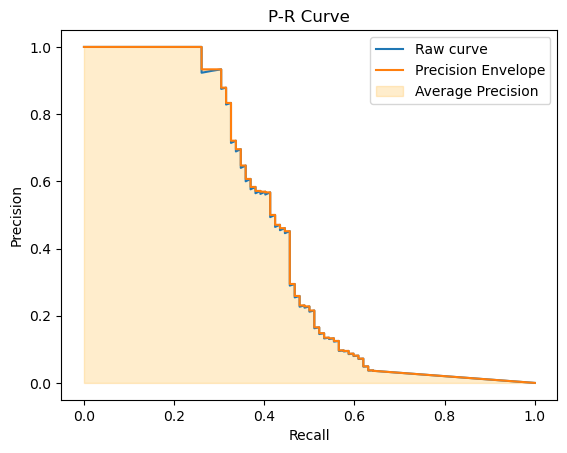

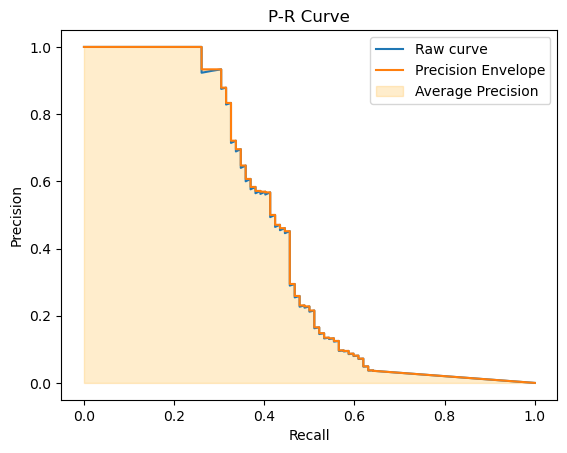

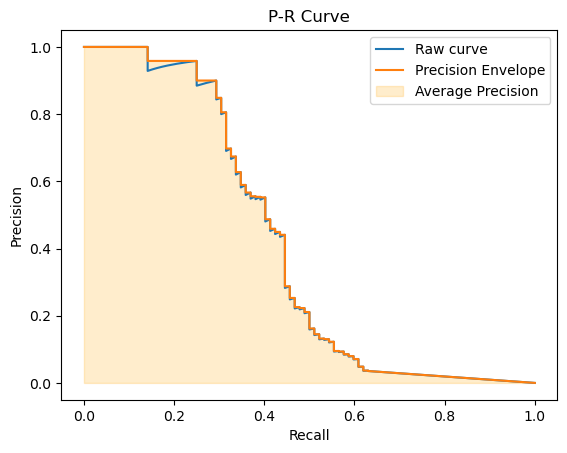

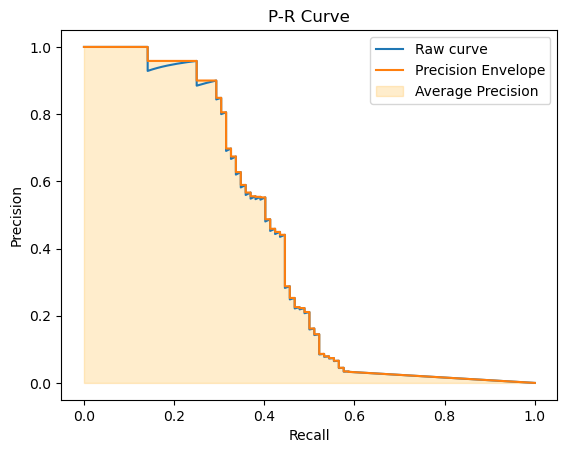

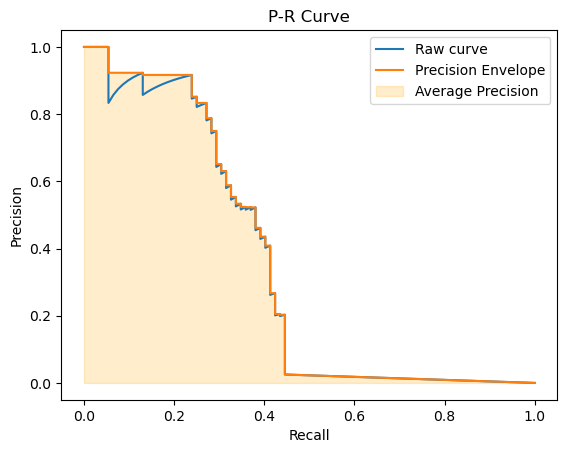

In [11]:
# Traverse over IoU threshold, get AP@[0.5:0.1:0.9]

for iou_thres in np.arange(0.5, 1.0, 0.1):
    ap, prec_raw, prec, recall = compute_ap(df, inputs['num_labels'], iou_thres)
    print('IoU Threshold: {:.2f}'.format(iou_thres), '  |    AP@{:.2f}'.format(iou_thres), ap)
    plot_pr_curves(recall, prec_raw, prec)